**Dependencies needed for recording videos**

In [1]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                            size=(1400, 900))
_ = _display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Explore the env**

In [2]:
import gym
env = gym.make("CartPole-v1")

print("Action Space: ", env.action_space)
print("State Space: ", env.observation_space)

Action Space:  Discrete(2)
State Space:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [3]:
# video record

from gym.wrappers.monitoring.video_recorder import VideoRecorder

before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state = env.reset()
for i in range(500):
  env.render()
  video.capture_frame()
  action = env.action_space.sample()
  next_state, reward, done, info = env.step(action)
  if i%100==0 or i==199:
    print("step", i, state, action, reward, next_state, done, info)
    pass
  pass
  state = next_state

video.close()
env.close()

step 0 [ 0.00623844  0.02462269 -0.04400296 -0.01852739] 0 1.0 [ 0.00673089 -0.16984149 -0.04437351  0.25995383] False {}


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step 100 [-0.50676077 -0.57724951 -7.05813727 -3.75947634] 1 0.0 [-0.51830576 -0.39126831 -7.1333268  -4.16449548] True {}
step 199 [ -2.41657899  -1.66457169 -21.74132349  -9.69361936] 0 0.0 [ -2.44987043  -1.88480932 -21.93519588 -10.08640705] True {}
step 200 [ -2.44987043  -1.88480932 -21.93519588 -10.08640705] 1 0.0 [ -2.48756661  -1.69608197 -22.13692402  -9.82020056] True {}
step 300 [ -1.01212635   2.78315104 -38.66520691  -7.50505787] 0 0.0 [ -0.95646333   2.56055242 -38.81530806  -7.557097  ] True {}
step 400 [  2.34761184   2.38558178 -55.81489654  -5.62756885] 1 0.0 [  2.39532347   2.58763203 -55.92744792  -5.65576458] True {}


In [4]:
# video -> html function

from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [5]:
# video play

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

**Start**

In [6]:
# import

import gym
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from collections import deque
from IPython import display

In [7]:
# cuda or not

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [8]:
# replay memory

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
        pass

    def push(self, state, action, reward, next_state, done):
        """Save a transition"""
        self.memory.append((state, action, reward, next_state, done))
        pass

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return torch.tensor(states,dtype=torch.float), torch.tensor(actions).view(-1,1), torch.tensor(rewards,dtype=torch.float).view(-1,1), torch.tensor(next_states,dtype=torch.float), torch.tensor(dones).view(-1,1)
        pass
    def __len__(self):
        return len(self.memory)
        pass      
    
    pass

In [9]:
# DQN

class DQN(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 32),
            nn.LeakyReLU(),
            # nn.LayerNorm(128),
            nn.Linear(32, 2)
        )

        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, states, actions, rewards, next_states, dones, target_net):
        GAMMA = 0.98

        Qsa0 = self.forward(states).gather(1, actions)
        Qsa1 = target_net.forward(next_states).max(1)[0].view(-1,1).detach()

        outputs = Qsa0
        targets = rewards + GAMMA*Qsa1*(~dones)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
       
    def train_count(self):
        return self.counter

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(alpha=0.1, marker='.', grid=True)
        pass
    
    pass

In [10]:
env = gym.make('CartPole-v1')

policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

CPU times: user 7min 16s, sys: 9.82 s, total: 7min 26s
Wall time: 7min 27s


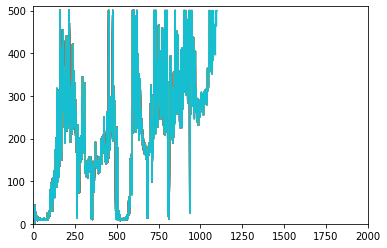

In [11]:
%%time
"""Training the agent"""

EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 200
BATCH_SIZE = 64
TARGET_UPDATE = 10

memory = ReplayMemory(10000)

num_episodes = 2000
durations = [0,0,0,0,0,0,0,0,0]

fig = plt.figure()
ax = plt.axes()
ax.set_xlim([0, num_episodes])
ax.set_ylim([0, 510])

for i_episode in range(num_episodes):

  state = env.reset()
  done = False
  duration = 0
  while not done:

    # sampling

    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * policy_net.train_count() / EPS_DECAY)

    if random.random() < eps_threshold:
      action = env.action_space.sample() # Explore action space
      pass
    else:
      action = policy_net.forward(torch.tensor(state, dtype=torch.float)).argmax().detach().item()
      pass

    next_state, reward, done, info = env.step(action)
    memory.push(state, action, reward, next_state, done)
    state = next_state

    duration += 1

    # training

    if len(memory) < BATCH_SIZE:
      continue

    states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)

    policy_net.train(states, actions, rewards, next_states, dones, target_net)

    pass

  # progress

  durations.append(duration)

  # udpate target_net
  # plot progress
  # check if ok to stop

  if i_episode % TARGET_UPDATE == 0:
    target_net.load_state_dict(policy_net.state_dict())

    ax.plot(durations)
    display.display(fig)
    display.clear_output(wait=True)

    if np.mean(durations[-10:-1]) > 475:
      break;
    pass

  pass

In [12]:
# video record

from gym.wrappers.monitoring.video_recorder import VideoRecorder

after_training = "after_training.mp4"
video = VideoRecorder(env, after_training)

state = env.reset()
done = False
i = 0
while not done:
  env.render()
  video.capture_frame()

  action = target_net.forward(torch.tensor(state, dtype=torch.float)).argmax().detach().item()
  next_state, _, done, _ = env.step(action)
  if done:
    print("duration", i)
    pass
  state = next_state
  i += 1
  
  pass

video.close()
env.close()

duration 499


In [13]:
# video -> html function

from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [14]:
# video play

from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)